In [2]:
import numpy as np
import os
import json
import gzip
import struct
import random
import time
import signal

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'gray'

from IPython.display import clear_output, display

from netlib import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
with gzip.open("data/charts/BTC-USD.json.gz", "rb") as f:
     data = json.loads(f.read().decode("utf-8"))
ohlcv = np.array([entry[1:5] for entry in data])
print(ohlcv)

[[ 231.145   231.145   230.18    230.18  ]
 [ 232.4786  232.4787  232.4786  232.4787]
 [ 232.4784  232.4785  232.4784  232.4785]
 ...
 [7321.3    7369.1    7319.8    7362.    ]
 [7361.7    7368.9    7315.7    7360.5   ]
 [7321.2    7351.8    7270.2    7275.8   ]]


In [4]:
avgs = 0.5*(ohlcv[:,0] + ohlcv[:,3])
data = np.log(avgs[1:]/avgs[:-1])
data = data - np.mean(data)
data = data/np.sqrt(np.var(data))
print("%s values in data" % data.shape[0])
print(data)

961831 values in data
[ 5.21975215e+00 -2.96427620e-03  3.27476745e-01 ...  1.25038085e+00
  1.75929870e+00 -5.68912776e+00]


In [7]:
val_size = 10000
tdata, vdata = data[:-val_size], data[-val_size:]
print("%s values in train data" % tdata.shape[0])

951831 values in train data


In [11]:
batch_size = 100

blen = len(tdata)//batch_size
print("%s values in sequence" % blen)
bseqdata = tdata[:blen*batch_size].reshape(batch_size, blen).transpose()
bseqdata = bseqdata.reshape(-1, batch_size, 1)

9518 values in sequence


In [12]:
signal_done = False

def signal_handler(signal, frame):
    global signal_done
    signal_done = True

def stop_on_signal():
    global signal_done
    signal_done = False
    signal.signal(signal.SIGINT, signal_handler)

In [23]:
def run_solvers(solvers, seqlen, pos=0, plot=True):
    stop_on_signal()
    while not signal_done:
        for i, sol in enumerate(solvers):
            rsl = seqlen*np.random.random()
            sol.learn(bseqdata[pos:pos+seqlen], bseqdata[pos+1:pos+seqlen+1])
        if plot:
            clear_output(wait=True)
            plot_solvers(plt, solvers)
        
        pos += seqlen
        if pos >= bseqdata.shape[0] - 1:
            pos = 0
    return pos

In [26]:
seqlen = 1440
hidden_size = 40

solvers = [
    RNNSolver(
        LSTM([1, hidden_size, 1]),
        optim, name=("LSTM %s" % (type(optim).__name__))
    ) for i, optim in enumerate([Adagrad(1e-3, decay=0.95), Adam(1e-3)])
]
pos = 0

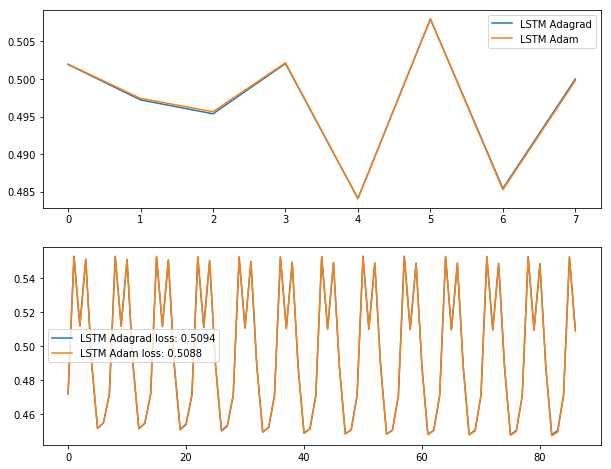

In [ ]:
pos = run_solvers(solvers, seqlen, pos)